#K Nearest Neighbors applied on GDP per capita

In this notebook we will briefly talk about what K Nearest Neighbors is, apply it to our data, and then we evaluate our model

K Nearest Neighbors looks at data points in the testing set and infers the classification based on similarity to other points of the same class in the training set. For example, assume we have a data point that we want to classify. If the closest other data point to our data point is a certain class, than 1 neighbor nearest neighbors will classify the new data point as the same class. 2 neighbor nearest neighbors takes into account the closest two data points, and so on. 

Definition - class: an output category of an ML model. 

In [ ]:
#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

#sklearn preprocessing and importing various ML models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import confusion_matrix

First, like the rest of the notebooks, we will merge and preprocess our datasets. All of this code has been previously explained in the merging notebook.

In [ ]:
# FUNCTIONS FROM SECTION 1
def merge_data(country_data, height_data):
  height_data = height_data.rename(columns={"Country Name" : "Country"})
  country_data['Country'] = country_data.apply(lambda row : row.astype(str)['Country'][:-1], axis=1)
  old_names = ['Antigua & Barbuda', 'Bahamas, The', 'Bosnia & Herzegovina', 'Central African Rep.', 'Congo, Dem. Rep.', 'Swaziland', 'Gambia, The', 'Cote d\'Ivoire',
             'Micronesia, Fed. St.', 'Burma', 'Korea, North', 'Macedonia', 'Congo, Repub. of the', 'Saint Kitts & Nevis', 'Sao Tome & Principe',
             'Korea, South', 'East Timor', 'Trinidad & Tobago']

  new_names = ['Antigua and Barbuda', 'Bahamas', 'Bosnia and Herzegovina', 'Central African Republic', 'DR Congo', 'Eswatini', 'Gambia', 'Ivory Coast', 'Micronesia',
              'Myanmar', 'North Korea', 'North Macedonia', 'Republic of the Congo', 'Saint Kitts and Nevis', 'Sao Tome and Principe', 'South Korea',
              'Timor-Leste', 'Trinidad and Tobago']

  for i in range(len(old_names)):
    country_data['Country'].replace({old_names[i]: new_names[i]}, inplace=True)
  
  merged_df = pd.merge(country_data, height_data, on=['Country'])
  return merged_df



# FUNCTIONS FROM SECTION 2
def rename_regions(row):
  if row['Region'] == 'ASIA (EX. NEAR EAST)':
    region = 'ASIA'
  elif row['Region'] == 'NEAR EAST':
    region = 'MIDDLE EAST'
  elif row['Region'] == 'C.W. OF IND. STATES':
    region = "C.W.I. STATES"
  else:
    region = row['Region']
  return region

def format_and_clean_data(merged_data):

  merged_data['Region'] = merged_data.apply(lambda row : row.astype(str)['Region'].strip(), axis=1)
  merged_data['Region'] = merged_data.apply(lambda row : rename_regions(row), axis=1)

  for col in merged_data.columns.values:
    # if there aren't any null values in this col, skip it
    if merged_data[col].isnull().sum() == 0:
        continue
    # if the col is climate, get the mode, or most common value, and use it as the guessed values
    if col == 'Climate':
        guess_values = merged_data.groupby('Region')['Climate'].apply(lambda x: x.mode())
    else:
    # in all other cases, get the median, or average, of the column grouped by the region
        guess_values = merged_data.groupby('Region')[col].median()
    # for each region in the data set, go through and find all of the null values and set them to the median for that region
    for region in merged_data['Region'].unique():
        merged_data[col].loc[(merged_data[col].isnull())&(merged_data['Region']==region)] = guess_values[region]

  return merged_data



def get_gdp_dataset(merged_data):
  """function's purpose is to combine the different height features into one average height 
  feature and select the crucial features necessary for our ML model"""

  #combine height attributes
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  #select crucial features
  GDP_features = ['GDP ($ per capita)', 'Infant mortality (per 1000 births)', 'Net migration', 'Pop. Density (per sq. mi.)',
                'Literacy (%)', 'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry', 'Service']
  gdp_data = merged_data[GDP_features]
  
  return gdp_data

We will read in the csv files for the gdp and height datasets and import them as pandas dataframes, that can then be manipulated by our merge and clean functions. 

In [ ]:
height_data = pd.read_csv('/content/Height_of_Male_and_Female_by_Country_2022.csv')
country_data = pd.read_csv('/content/countries_of_the_world.csv', decimal=',')

merged_data = merge_data(country_data, height_data)
merged_data = format_and_clean_data(merged_data)
gdp_data = get_gdp_dataset(merged_data)

gdp_data.head()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
0,700.0,163.07,23.06,48.0,36.0,3.2,46.60,0.380,0.240,0.380
1,4500.0,21.52,-4.93,124.6,86.5,71.2,15.11,0.232,0.188,0.579
2,6000.0,31.00,-0.39,13.8,70.0,78.1,17.14,0.101,0.600,0.298
3,8000.0,9.27,-20.71,290.4,97.0,259.5,22.46,0.151,0.190,0.620
4,19000.0,4.05,6.60,152.1,100.0,497.2,8.71,0.021,0.274,0.707


#Split into training and testing data. 

Definition: Features are the attributes of each data point entered into the model, and labels are what we are trying to predict.

We first need to split our data into training and testing. If a machine learning model is trained and tested on the same section of data, the model can memorize the data and perform perfectly. This, however, does not give us a clear picture of how the model will perform in the real world. We want to test the model on a section of data that the model hasn't seen before. 

The features that we will enter into the model, and the target we want to predict are outlined below. Split the features and labels into training and testing, with 30% of our data being allocated toward testing. 

X_train and y_train are respectively the features and labels we will be training on, and X_test and y_test are the features and labels we will be testing on.  


In [ ]:
#features we want to train on
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']

#target we want to predict using the features (GDP)
target = 'GDP ($ per capita)'

#get the features we want to use from the main dataset, and the labels
features = gdp_data[training_features]
labels = gdp_data[target]

#split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True)

#Training and Evaluation
As discussed before, a nearest neighbors classifier takes in parameter for the number of neighbors. To recap, these are the closest n points to the new point that our model uses to make a decision. If a plurality of close points are a certain class, that is the predicted class of our new point. 

We use the sklearn .fit command, entering the training and testing data to tune the model toward better predictions. 

Next is the evaluation phase. We predict, for X_test (the testing features), outputs for each of these data points. Comparing these outputs of our ML model to actual values (y_test), we can find the average difference between the predicted outputs and the actual outputs. This is defined as mean absolute error. 

Because we want to test the difference between predicted outputs and actual outputs, both being continuous values, we will be using a regression version of a neighbors model called KNeighborsRegressor instead of KNeighborsClassifier.

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=5)

#fitting the model to our dataset
neigh.fit(X_train, y_train)

#getting all our predictions from the ML model
predictions = neigh.predict(X_test)

#average difference between the predicted outputs and the actual outputs
print(mean_absolute_error(np.array(y_test), predictions))

0.5796610169491525


Next, we want to cut our GDP per capita into five distinct classes, such as very poor, poor, average, wealthy, and very wealthy. This is to attempt classification of our dataset and visualize a confusion matrix of our results (explained later). To split a column into classes, we will be using the pd.qcut method. 

In [ ]:
gdp_data['GDP ($ per capita)'] = pd.qcut(gdp_data['GDP ($ per capita)'], 5, labels=False)
gdp_data.describe()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
count,195.000000,195.000000,195.000000,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.000000,38.936846,-0.437077,201.308205,82.29641,198.387179,22.889744,0.158349,0.293564,0.547195
std,1.417854,36.382098,4.466701,667.646406,20.01014,199.670583,11.359249,0.149453,0.135160,0.154904
min,0.000000,2.290000,-20.990000,0.000000,17.60000,0.200000,7.290000,0.000000,0.040000,0.062000
25%,1.000000,10.020000,-1.315000,26.800000,69.95000,27.100000,12.835000,0.039000,0.203500,0.425500
50%,2.000000,24.310000,0.000000,69.800000,92.30000,131.800000,20.690000,0.112000,0.275000,0.560000
75%,3.000000,62.550000,0.305000,151.000000,98.00000,305.550000,30.815000,0.231000,0.349000,0.665000
max,4.000000,191.190000,23.060000,6482.200000,100.00000,898.000000,50.730000,0.769000,0.906000,0.906000


In [ ]:
### perform train test split on our new data ###

#features we want to train on
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']

#target we want to predict using the features (GDP)
target = 'GDP ($ per capita)'

#get the features we want to use from the main dataset, and the labels
features = gdp_data[training_features]
labels = gdp_data[target]

#split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True)

In [ ]:
target

'GDP ($ per capita)'

In [ ]:
#view different classes in targets
y_train[0:5]

171    4
160    1
40     0
130    0
125    0
Name: GDP ($ per capita), dtype: int64

To train on our new features and targets, we will use a KNeighborsClassifier because we are attempting to predict discrete categories, or classes, such as poor and wealthy. Otherwise, the training process is the exact same as above,so refer above for the explanation. 

Additionally, we will use a confusion matrix to visualize our results. 

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
cf_matrix = confusion_matrix(np.array(y_test), predictions)
cf_matrix

array([[ 6,  1,  1,  0,  0],
       [ 5,  2,  3,  1,  0],
       [ 1,  5,  4,  2,  0],
       [ 0,  2,  7,  3,  0],
       [ 0,  0,  2,  2, 12]])

#Confusion Matrix
A confusion matrix for a classification problem tells us the number of correct and incorrect predictions for every class (for example wealthy). More precisely, for every class in our dataset, the confusion matrix will tell us how many true examples in that class were predicted as each other class. 

As an arbitrary example, the model may have classified 10 countries with average GDP as average and 1 country with average GDP as wealthy, and 3 countries with average GDP as poor. 

To show this, we will use a seaborn heatmap. 

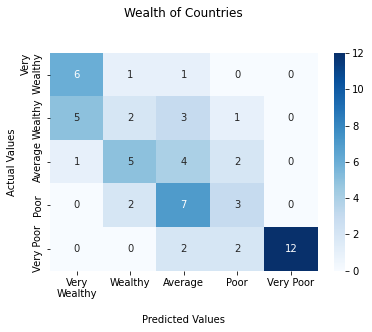

In [ ]:
#heatmap of confusion matrix
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

#title and axis labels
ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

## Ticket labels of every class - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Very\nWealthy','Wealthy','Average','Poor','Very Poor'])
ax.yaxis.set_ticklabels(['Very\n Wealthy','Wealthy','Average','Poor','Very Poor'])

## Display the visualization of the Confusion Matrix.
plt.show()

Finally, we will show each of the values in the confusion matrix as a percentage of the total predictions for the class in question. For example, average GDP countries predicted as wealthy will be shown as a percentage of the total countries with average GDP. 

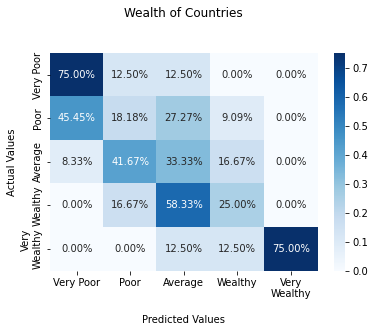

In [ ]:
#converting all the confusion matrix values to percentages
cf_matrix = confusion_matrix(np.array(y_test), predictions)
percent_matrix = []
for i in range(len(cf_matrix)):
  percent_matrix.append(cf_matrix[i]/sum(cf_matrix[i]))

ax = sns.heatmap(percent_matrix, annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])
ax.yaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])

plt.show()

##Accuracy score
One final metric that we could use is accuracy score, for categorical predictions. Accuracy score is simply the number of correct predictions over the total number of predictions. For example, a 100% accuracy (while suspicious) means that our model got 100% of the testing examples correct. 

In [ ]:
accuracy_score(np.array(y_test), predictions)

0.4067796610169492